# Meta

Made on 2023-01-09, redoing `demag_analysis_v1` bc stupid misconceptions.

BEFORE YOU RUN:
* run `getdata.sh`, or follow the instructions in the comments of that file
* make sure jupyter is launched from the main repository directory (i.e. the path to this file should be "/code/04..."

## Table of Contents (incomplete)

1. Setup
    - `lon2clon`, etc
    - `print_dict(d)`

2. HPEs
    - GRS data:
        ```
        grs = GRS("data/GRS/smoothed")
        grs.loadData()
        grs.visualize(element)
        grs.getConcentration(lon, lat, element)
        grs.getAdjustedConcentration(lon, lat, element)grs = GRS("data/GRS/smoothed")
        ```
        \
    - Crustal heat flow:
        ```
        calc_H(lon, lat, t)
        ```
        \
    - Curie Depth

---
# Setup

## Imports

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import os

## Useful Functions

In [2]:
"""
function [clon] = lon2clon(lon)  
    clon = mod(lon,360);
end

function [lon] = clon2lon(clon)  
    lon = mod(clon-180,360)-180;
end
"""

def lon2clon(lon):
    return lon % 360
def clon2lon(clon):
    return ((clon-180) % 360) - 180

def lat2cola(lat):
    return lat % 180
def cola2lat(cola):
    return ((cola-90) % 180) - 90
# def lat2cola(lat):
#     return lat + 90
# def cola2lat(cola):
#     return cola - 90



# pretty display of dictionary
def print_dict(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            print_dict(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

---
# HPEs

## Load/Access GRS Data

### **Main: GRS Class**

In [3]:
class GRS:
    
    nanval = 0
    
    def __init__(self, relpath_datafolder):
        self.relpath_datafolder = relpath_datafolder
        return
    
    
    def loadData(self):
        ## load data from files
        self.data = []
        path_datafolder = os.path.abspath(os.path.join(os.getcwd(), self.relpath_datafolder))
        for datafilename in (os.listdir(path_datafolder)):            
            if ".tab" in datafilename:

                # read file
                datafile = open(os.path.abspath(os.path.join(os.getcwd(), self.relpath_datafolder, datafilename)), 'r')
                rawdata = datafile.readlines()
                datafile.close()

                # populate lon/lat values if first time
                if self.data == []: # populate lon/lat values
                    # loop setups
                    prevlat = None
                    thisline = []
                    for rawdataline in rawdata:
                        rawdataline = rawdataline.split()
                        thislat = float(rawdataline[0])
                        thisclon = float(rawdataline[1])
                        thiscola = lat2cola(thislat)
                        thislon = clon2lon(thisclon)
                        # thisconc = rawdataline[2]
                        if thislat != prevlat and prevlat != None:
                            self.data.append(thisline)
                            thisline = []
                        thisline.append({"lon": thislon, "lat": thislat, "clon": thisclon, "cola": thiscola})
                        prevlat = thislat
                    self.data.append(thisline)

                # populate data values                
                elementname = datafilename[:datafilename.index("_")]
                counter = 0
                for i in range(len(self.data)):
                    for j in range(len(self.data[0])):
                        # rawdataline = rawdataline.split()
                        thisconc = float(rawdata[counter].split()[2])
                        self.data[i][j][elementname] = thisconc if thisconc != 9999.999 else self.nanval
                        counter += 1
                        
        ## adjust longitude (realign to look like my qgis lol)
        lons = []
        for i in range(len(self.data[0])):
            lons.append(self.data[0][i]["lon"])
        # print(lons)
        for i in range(len(lons)):
            if lons[i] < 0:
                break
        for k in range(len(self.data)):
            self.data[k] = self.data[k][i:] + self.data[k][:i]
        return
    
    
    
    # def fixUnits(self):
    #     # put wt% in terms of decimal proportions (1% -> 0.01, ie 10e-2)
    #     # put ppm for Th to decimal proportions (1 ppm -> 0.000001, ie 10e-6)
    #     for lat in range(len(self.data)):
    #         for lon in range(len(self.data[0])):
    #             for key in self.data[lat][lon]:
    #                 if key == "th":
    #                     self.data[lat][lon][key] *= 10e-6
    #                 elif key != "kvsth":
    #                     self.data[lat][lon][key] *= 10e-2
    #     return





#     def visualize(self, elementname):
#         test = []
#         for i in range(len(self.data)):
#             newline = []
#             for j in range(len(self.data[0])):
#                 val = self.data[i][j][elementname]
#                 newline.append(val if val < 9000 else self.nanval)
#                 # print
#             test.append(newline)
#         plt.imshow(test[::-1], cmap="jet")
#         plt.colorbar()
#         return

    def visualize(self, elementname):

        test = []
        for i in range(len(self.data)):
            newline = []
            for j in range(len(self.data[0])):
                val = self.data[i][j][elementname]
                newline.append(val if val < 9000 else self.nanval)
                # print
            test.append(newline)
        
        fig = plt.figure(figsize=(7,5))
        ax = plt.axes()
        im = ax.imshow(test[::-1], cmap="jet")

        cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        
        
        
        
    
    def getConcentration(self, lon, lat, elementname, normalized = False):

        
        if normalized:
            return self.getAdjustedConcentration(lon, lat, elementname)
        else:
            clon = lon2clon(lon)
            cola = lat2cola(lat)

            ## get lon/clon/lat/cola lists for easy searching
            
            lons = []
            for i in range(len(self.data[0])):
                lons.append(self.data[0][i]["lon"])
            # print(lons)
            clons = [lon2clon(lon) for lon in lons]
            # print(clons)
            
            lats = []
            for i in range(len(self.data)):
                lats.append(self.data[i][0]["lat"])
            # print(lats)
            colas = [lat2cola(lat) for lat in lats]
            # print(colas)

            ## get indexes and values for four nearest pixels

            if lon <= lons[0] or lon >= lons[-1]: # edge cases
                i_lon_left = len(lons)-1
                i_lon_right = 0
                lon_left = lons[i_lon_left]
                lon_right = lons[i_lon_right]
            else: # everything else
                for i in range(len(lons)):
                    if lon < lons[i]:
                        i_lon_left = i-1
                        i_lon_right = i
                        lon_left = lons[i_lon_left]
                        lon_right = lons[i_lon_right]
                        break

            if lat <= lats[0] or lat >= lats[-1]: # edge cases
                i_lat_bottom = len(lats)-1
                i_lat_top = 0
                lat_bottom = lats[i_lat_bottom]
                lat_top = lats[i_lat_top]
            else: # everything else
                for i in range(len(lats)):
                    if lat < lats[i]:
                        i_lat_bottom = i-1
                        i_lat_top = i
                        lat_bottom = lats[i_lat_bottom]
                        lat_top = lats[i_lat_top]
                        break


            top_left = self.data[i_lat_top][i_lon_left][elementname]
            top_right = self.data[i_lat_top][i_lon_right][elementname]
            bottom_left = self.data[i_lat_bottom][i_lon_left][elementname]
            bottom_right = self.data[i_lat_bottom][i_lon_right][elementname]

            ## testing

            # print(f"{lat_bottom} {lon2clon(lon_left)} {bottom_left}")
            # print(f"{lat_bottom} {lon2clon(lon_right)} {bottom_right}")
            # print(f"{lat_top} {lon2clon(lon_left)} {top_left}")
            # print(f"{lat_top} {lon2clon(lon_right)} {top_right}")
            # print()
            # print(lon_left)
            # print(lon_right)
            # print(lat_bottom)
            # print(lat_top)

    #         ## dealing with negative/NaN values
    #         num_reals = 4
    #         avg = 0
    #         if top_left != -1:
    #             num_reals -= 1
    #             avg += top_left
    #         if top_right != -1:
    #             num_reals -= 1
    #             avg += top_right
    #         if bottom_left != -1:
    #             num_reals -= 1
    #             avg += bottom_left
    #         if bottom_right != -1:
    #             num_reals -= 1
    #             avg += bottom_right

    #         avg /= num_reals

            ## bilinear interpolation

            clon_left = lon2clon(lon_left)
            clon_right = lon2clon(lon_right)
            cola_bottom = lat2cola(lat_bottom)
            cola_top = lat2cola(lat_top)


            if abs(i_lon_right - i_lon_left) == 1: # somewhere in the middle
                londist = abs(lon_right-lon_left)
                leftdist = (lon-lon_left) / londist
                rightdist = (lon_right-lon) / londist
            else: # on the edges
                londist = abs(clon_right-clon_left)
                leftdist = (clon-clon_left) / londist
                rightdist = (clon_right-clon) / londist
            # print(londist)
            topinterp = top_left*(1-leftdist) + top_right*(1-rightdist)
            bottominterp = bottom_left*(1-leftdist) + bottom_right*(1-rightdist)


            if abs(i_lat_top - i_lat_bottom) == 1: # somewhere in the middle
                latdist = abs(lat_top-lat_bottom)
                bottomdist = (lat-lat_bottom) / latdist
                topdist = (lat_top-lat) / latdist
            else: # on the edges
                latdist = abs(cola_top-cola_bottom)
                bottomdist = (cola-cola_bottom) / latdist
                topdist = (cola_top-cola) / latdist    
            # print(latdist)

            finalinterp = topinterp*(1-topdist) + bottominterp*(1-bottomdist)

            if elementname == "th":
                # finalinterp *= 1e-6
                finalinterp *= 10**-6
            else:
                # finalinterp *= 1e-2
                finalinterp *= 10**-2

            return finalinterp

            # return [londist, latdist]
        
        
    def getAdjustedConcentration(self, lon, lat, elementname):
        """
        "Groundwater production from geothermal heating on early Mars and implication for early martian habitability"
            Ojha et al. 2020
            https://www.science.org/doi/10.1126/sciadv.abb1669
            
        > For such measurement to represent the bulk chemistry of the martian upper crust, it must be normalized to 
        > a volatile-free basis (22). That equates to a 7 to 14% increase in the K, Th, and U abundances (22), which 
        > we applied to the chemical maps by renormalizing to Cl, stoichiometric H2O, and S-free basis.
        """
        
        init_conc = self.getConcentration(lon, lat, elementname, normalized=False)
        # if elementname == "th":
        #     init_conc *= 10e-4
        
        sum_volatile_conc = 0
        for volatile in ["cl", "h2o", "si"]:
            this_conc = self.getConcentration(lon,lat, volatile, normalized=False)
            # print(this_conc)
            if this_conc > 0:
                sum_volatile_conc += this_conc
        # print(sum_volatile_conc)
        # init_conc *= (1)/(1-(sum_volatile_conc/100))
        init_conc *= (1)/(1-(sum_volatile_conc))
        
        return init_conc
        
        
        
        
#     def normalize(self):
#         """
#         "Groundwater production from geothermal heating on early Mars and implication for early martian habitability"
#             Ojha et al. 2020
#             https://www.science.org/doi/10.1126/sciadv.abb1669
            
#         > For such measurement to represent the bulk chemistry of the martian upper crust, it must be normalized to 
#         > a volatile-free basis (22). That equates to a 7 to 14% increase in the K, Th, and U abundances (22), which 
#         > we applied to the chemical maps by renormalizing to Cl, stoichiometric H2O, and S-free basis.
#         """
        
#         # self.datanorm = self.data
        
#         for lat in range(len(self.datan)):
#             for lon in range(len(self.datan[0])):
#                 valid_flag = True
#                 sum_volatiles = 0
#                 for volatile in ["cl", "h2o", "si"]:
#                     if self.data[lat][lon][volatile] > 0:
#                         sum_volatiles += self.data[lat][lon][volatile]
#                         self.datan[lat][lon][volatile] = -1
#                     else:
#                         valid_flag = False
#                 self.datanorm[lat][
        
        
#         return

### Example 1: test GRS class

Unnormalized Th concentration: 5.9125e-07
Normalized Th concentration: 8.05443641082053e-07



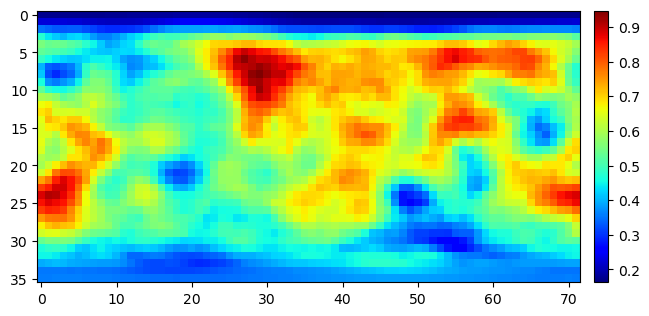

In [4]:
grs = GRS("data/GRS/smoothed")
grs.loadData()
grs.visualize("th")



# a = grs.getConcentration(10, 0, "th")
# grs.fixUnits()
# b = grs.getConcentration(10, 0, "th")
# print(a)
# print(b)
# print(b/a)


# grs.visualize("th")
# print(grs.getConcentration(0, 0, "cl"))
# print(grs.getConcentration(0, 0, "h2o"))
# print(grs.getConcentration(0, 0, "si"))


# print(grs.getConcentration(0, 0, "th"))
# print()
print(f"Unnormalized Th concentration: {grs.getConcentration(0, 0, 'th', normalized=False)}")
print(f"Normalized Th concentration: {grs.getConcentration(0, 0, 'th', normalized=True)}")
print()
# print()
# print(grs.getConcentration(0, 0, "th") * (1/(1-0.2659325)))

### Example 2: fully interpolated element map 

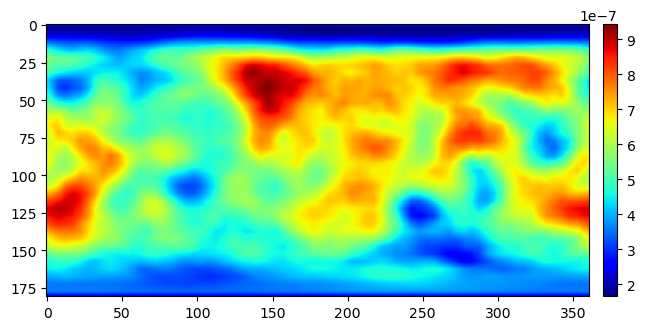

In [5]:
grs = GRS("data/GRS/smoothed")
grs.loadData()

test = []
for lat in range(-90,91):
    newline = []
    for lon in range(-180,181):
        newline.append(grs.getConcentration(lon,lat,"th"))
    test.append(newline)

# plt.imshow(test[::-1], cmap="jet")
# plt.colorbar()

fig = plt.figure(figsize=(7,5))
ax = plt.axes()
im = ax.imshow(test[::-1], cmap="jet")

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

---
## Crustal Heat Flow Calculation

### Main: Calculate crustal heat production

Mean heat generation per unit mass in a crust from the decay of radioactive elements uranium, thorium, and potassium. 

Read more in chapter 4 of Geodynamics by Turcotte and Schuber.

In [6]:
"""
Constants from:
    - "Amagmantic Hydrothermal Systems on Mars from Radiogenic Heat", by Ojha et al. 2021,
    - "Geodynamics", by Turcotte & Schubert 2014.
"""

HPE = {
    "U238": {
        "isotopic_frac": 0.9928,
        "heat_release_const": 9.46e-5, # net energy per unit mass [W/kg]
        "half_life": 4.47e9
    },
    "U235": {
        "isotopic_frac": 0.0071,
        "heat_release_const": 5.69e-4,
        "half_life": 7.04e8
    },
    "Th232": {
        "isotopic_frac": 1.00,
        "heat_release_const": 2.64e-5,
        "half_life": 1.40e10
    },
    "K40": {
        "isotopic_frac": 1.191e-4,
        "heat_release_const": 2.92e-5,
        "half_life": 1.25e9
    }
}

            
# print_dict(HPE)

def calc_H(lon, lat, t, volatile_adjusted = False):
    
    ## setup
    thisHPE = HPE
    grs = GRS("data/GRS/smoothed")
    grs.loadData()
    
    
    ## get concentrations
    for element in thisHPE:
        # print(element)
        elementname = ''.join([char for char in element if not char.isdigit()]).lower()
        # print(elementname)
        if elementname == "u":
            ## cosmochemically constant Th/U mass ratio of 3.8
            concentration = grs.getConcentration(lon, lat, "th", normalized=volatile_adjusted) / 3.8
            # if volatile_adjusted:
            #     concentration = grs.getAdjustedConcentration(lon, lat, "th") / 3.8
            # else:
            #     concentration = grs.getConcentration(lon, lat, "th") / 3.8
        else:
            concentration = grs.getConcentration(lon, lat, elementname, normalized=volatile_adjusted)
            # if volatile_adjusted:
            #     concentration = grs.getAdjustedConcentration(lon, lat, elementname)
            # else:
            #     concentration = grs.getConcentration(lon, lat, elementname)
        thisHPE[element]["concentration"] = concentration
        # print(concentration)
    # print_dict(thisHPE)
    
    
    ## calculate crustal heat production
    q_c = 0
    for element in thisHPE:
        q_c += (
            thisHPE[element]["isotopic_frac"] 
            * thisHPE[element]["concentration"] 
            * thisHPE[element]["heat_release_const"] 
            * math.exp((t * math.log(2))/(thisHPE[element]["half_life"]))
        )

    return q_c

# print(calc_H(1,1,1))

### Example 1: $H$ map

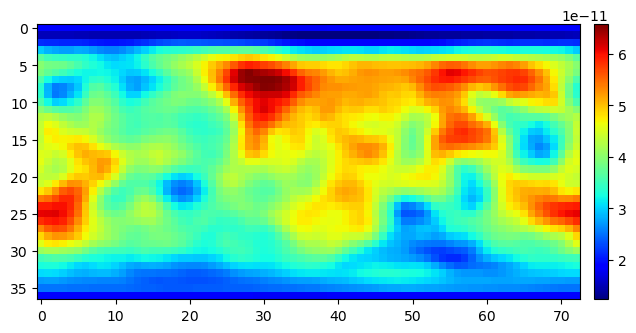

In [7]:
grs = GRS("data/GRS/smoothed")
grs.loadData()

test = []
for lat in range(-90,91,5):
    newline = []
    for lon in range(-180,181,5):
        # val = grs.getConcentration(lon,lat,"th")
        val = calc_H(lon, lat, 1)
        newline.append(val)
    test.append(newline)

# plt.imshow(test[::-1], cmap="jet")
# plt.colorbar()

fig = plt.figure(figsize=(7,5))
ax = plt.axes()
im = ax.imshow(test[::-1], cmap="jet")

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

### Example 2: Read/plot Luju's matfile

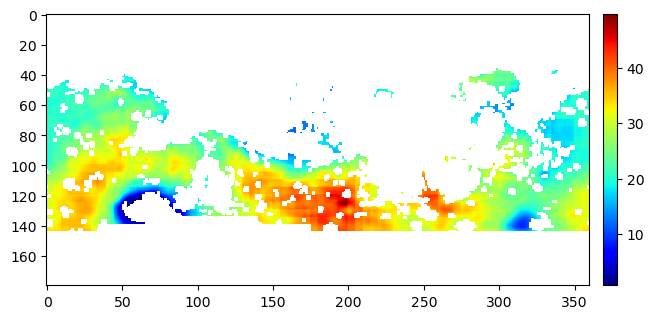

In [8]:
# datafolder = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data"))
datafolder = os.path.abspath(os.path.join(os.getcwd(), "data/crustal_heat_flow"))

matfile = sio.loadmat(os.path.abspath(os.path.join(datafolder, "HcrGRS_Hm0.mat")))

H_cr = matfile['nhf']

# fig, ax = plt.subplots(figsize=(15,10))
# plot = ax.imshow(H_cr, cmap='jet')
# plt.colorbar(plot)


fig = plt.figure(figsize=(7,5))
ax = plt.axes()
im = ax.imshow(H_cr,cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
print()

# print(len(H_cr))
# print(len(H_cr[0]))

# def calc_q0(lon, lat):
#     x = -lat - 90
#     y = lon2clon(lon)
#     return (H_cr[int(x)][int(y)])

# # calc_q0(23.4, 10.8)

### Example 3: Manually check $H$ at Henry Crater

In [9]:
henry = {
    "lon": 23.4,
    "lat": 10.8,
    "formation": 3.6e9
}

# craters = []
# craters.append(henry)


## manually check calculation

grs = GRS("data/GRS/smoothed")
grs.loadData()

C_u = grs.getConcentration(henry["lon"], henry["lat"], "th") / 3.8

q_c = (
    0.9928 * C_u * 9.46e-5 * math.exp((henry["formation"] * math.log(2))/(4.47e9))
    + 0.0071 * C_u * 5.69e-4 * math.exp((henry["formation"] * math.log(2))/(7.04e8))
    + grs.getConcentration(henry["lon"], henry["lat"], "th") * 2.64e-5 * math.exp((henry["formation"] * math.log(2))/(1.40e10))
    + 1.191e-4 * grs.getConcentration(henry["lon"], henry["lat"], "k") * 2.92e-5 * math.exp((henry["formation"] * math.log(2))/(1.25e9))
)

################

th = grs.getConcentration(henry["lon"], henry["lat"], "th")
k = grs.getConcentration(henry["lon"], henry["lat"], "k")

print(f"Th concentration (ppm): {th*10**6}")
print(f"K concentration (wt%): {k*10**2}")


print()
################


print(f"Manual: {q_c}")

x = calc_H(henry["lon"], henry["lat"], henry["formation"], volatile_adjusted=False)
print(f"Function: {x}")

diff = 100*(q_c-x)/q_c
print(f"% Diff: {diff}")

Th concentration (ppm): 0.7315072
K concentration (wt%): 0.333192

Manual: 1.6690218866827982e-10
Function: 1.6690218866827982e-10
% Diff: 0.0


Saved outputs:

```
Th concentration (ppm): 0.7315072
K concentration (wt%): 0.333192

Manual: 1.6690218866827982e-10
Function: 1.6690218866827982e-10
% Diff: 0.0
```

which matches given picture maps: https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/browse.htm

NOTE: this uses unadjusted concentrations -- whether the adjustments are correct or not is irrelevant, this was just to make sure my code matches manual calculation

---
## Curie Depth Calculation

### Main: 1D Temp/Depth Profile

1D steady heat conduction with volumetric heat production.

(Assuming surface temp is 273K)

In [65]:
henry = {
    "lon": 23.4,
    "lat": 10.8,
    "formation": 3.6e9,
    "diameter_km": 300, # 167.58,
}

### Standard method

From "Geodynamics" by Turcotte and Schubert:

$$
T(z) = \frac{q_0}{k}z-\frac{\rho H}{2k}z^2
$$

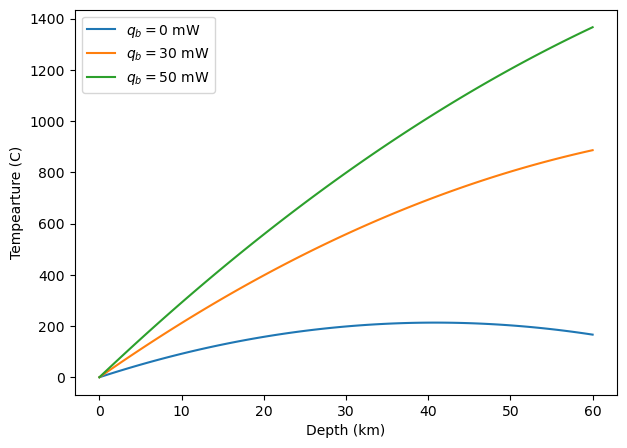

In [16]:
def tempAtDepth(lon, lat, t, depth_km, q_b_mW, volatile_adjusted = False):
    '''WARNING: THIS IS A CONSTLY COMPUTATION bc `calc_H`, do not run this function for a large dataset :3'''
    
    ## Work with luju's matfile
    def calc_Qs(lon, lat):
        datafolder = os.path.abspath(os.path.join(os.getcwd(), "data/crustal_heat_flow"))
        matfile = sio.loadmat(os.path.abspath(os.path.join(datafolder, "HcrGRS_Hm0.mat")))
        # print(matfile)
        H_cr = matfile['nhf']
        # H_cr = matfile['hf_m20']
        x = -lat - 90
        y = lon2clon(lon)
        return (H_cr[int(x)][int(y)] * 10**-3) # file given in mW, convert to [W m^-2]
    
    
    q_s = calc_Qs(lon,lat) # surface heat flow [W m^-2]
    # q_b = 30e-3 # basal heat flow, parameter sweep this from 0-50 -- this is what we can figure out using sph harmonics and impact modelling!
    q_b = q_b_mW * 10**-3 # basal heat flow, parameter sweep this from 0-50 -- this is what we can figure out using sph harmonics and impact modelling!
    q_0 = q_s + q_b
    k_cr = 2.5 # thermal conductivity of crust [W m^-1 K^-1]
    rho = 2800 # density of crust [kg m^-3]
    H = calc_H(lon, lat, t, volatile_adjusted) # heat production due to HPEs [W kg^-1]
    
    depth_m = depth_km*1000

    
    T = ((q_0 * depth_m)/(k_cr)) - ((rho * H * depth_m**2)/(2*k_cr))
    return T


############################################
depths_km = np.linspace(0, 60, 100)
temps_C_hm0 = [tempAtDepth(henry["lon"], henry["lat"], henry["formation"], depth_km=z, q_b_mW = 0, volatile_adjusted = True) for z in depths_km]
temps_C_hm30 = [tempAtDepth(henry["lon"], henry["lat"], henry["formation"], depth_km=z, q_b_mW = 30, volatile_adjusted = True) for z in depths_km]
temps_C_hm50 = [tempAtDepth(henry["lon"], henry["lat"], henry["formation"], depth_km=z, q_b_mW = 50, volatile_adjusted = True) for z in depths_km]



fig = plt.figure(figsize=(7,5))
ax = plt.axes()

hm0, = ax.plot(depths_km, temps_C_hm0)
hm30, = ax.plot(depths_km, temps_C_hm30)
hm50, = ax.plot(depths_km, temps_C_hm50)

ax.legend(
    handles = [hm0, hm30, hm50],
    labels = ["$q_b = 0$ mW", "$q_b = 30$ mW", "$q_b = 50$ mW"]
)

ax.set_xlabel("Depth (km)")
ax.set_ylabel("Tempearture (C)")

plt.show(ax)

In [12]:
# tempAtDepth(henry["lon"], henry["lat"], henry["formation"], 1)

### Luju's Method

From supplemental text 3 of "Depletion of Heat Producting Elements in the Martian Mantle" by Ojha et al. 2019:

$$
T( z) =\begin{cases}
\frac{\rho Hz}{\kappa _{c}}\left( z_{\text{crust}} -\frac{z}{2}\right) +\frac{q_{b} z}{\kappa _{c}} & ,\{z< z_{\text{crust}}\}\\
\frac{\rho Hz_{\text{crust}}^{2}}{2\kappa _{m}} +\frac{q_{b} z}{\kappa _{m}} & ,\{z >z_{\text{crust}}\}
\end{cases}
$$

Many constants come from this paper as well.

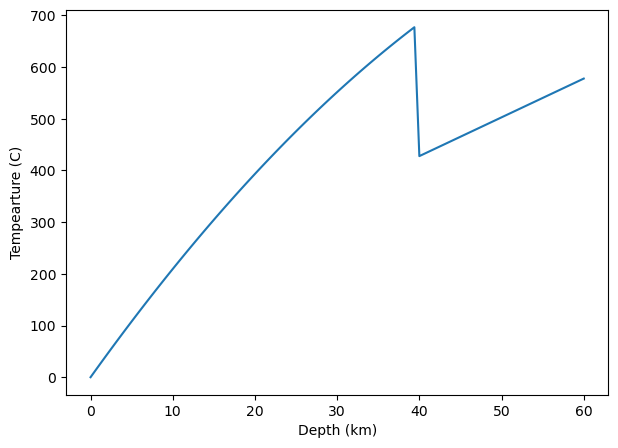

In [13]:
def tempAtDepth(lon, lat, t, depth_km, volatile_adjusted = False):
    
    '''WARNING: THIS IS A CONSTLY COMPUTATION bc `calc_H`, do not run this function for a large dataset :3'''
    
    rho = 2800 # density of crust [kg m^-3]
    H = calc_H(lon, lat, t, volatile_adjusted) # heat production in crust [W kg^-1]
    k_cr = 2.5 # thermal conductivity of crust [W m^-1 K^-1]
    k_m = 4 # thermal conductivity of mantle [W m^-1 K^-1]
    thickness_crust_m = 40e3 # from random map i found online -- eventually automate this!
    q_b = 30e-3 # basal heat flow, parameter sweep this from 0-50 -- this is what we can figure out using sph harmonics and impact modelling!
    depth_m = depth_km*1000
    
    if depth_m < thickness_crust_m:
        T = ((rho * H * depth_m)/(k_cr))*(thickness_crust_m - depth_m/2) + (q_b * depth_m)/(k_cr)
    else:
        T = ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * depth_m)/(k_m))
        
    return T
    

############################################
depths = np.linspace(0, 60, 100)
temp = [tempAtDepth(henry["lon"], henry["lat"], henry["formation"], depth_km=z, volatile_adjusted = True) for z in depths]


fig = plt.figure(figsize=(7,5))
ax = plt.axes()
ax.plot(depths, temp)

ax.set_xlabel("Depth (km)")
ax.set_ylabel("Tempearture (C)")

plt.show(ax)

---
# Impact Demag

In [85]:
henry = {
    "lon": 23.4,
    "lat": 10.8,
    "formation": 3.6e9,
    "diameter_km": 300 # 167.58,
}

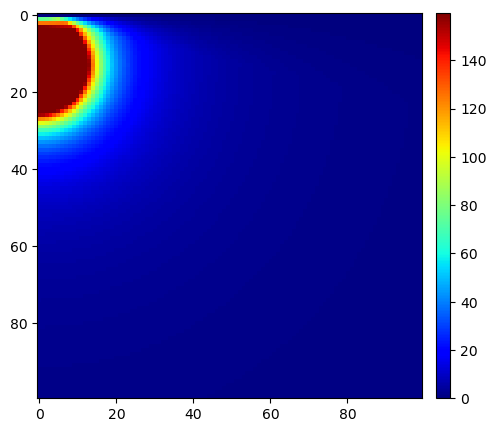

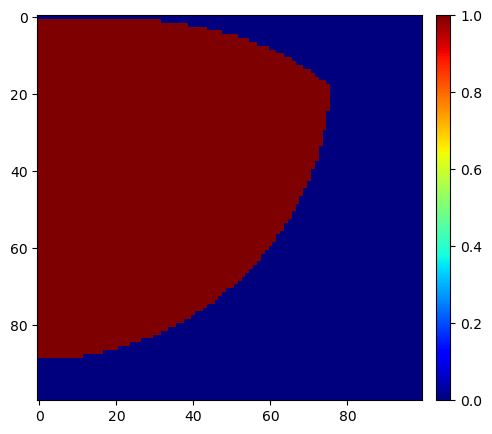

In [108]:
def calc_P(diameter_km, r_km, z_km):
    
    ## unit conversions
    diameter_m = diameter_km * 1000
    r_m = r_km * 1000 # horizontal distance from impact site
    z_m = z_km * 1000 # depth from floor of crater (?)
    
    
    ## start complicated math shit -- NOTE THAT EVERYTHING IS IN SI, I.E. METERS NOT KILOMETERS!!!
    
    diam_obs = diameter_m # observed crater diameter
    diam_star = 7 * 1000 # transition diameter from simple to complex crater, assumed 7km for mars
    diam_trans = 0.7576 * (diam_obs ** 0.921) * (diam_star ** 0.079)
    # print(diam_trans / 1000)
    
    v_proj = 10 * 1000 # impact velocity, varies from 8-12 km/s, assumed 10 km/s
    g = 3.721 # surface gravity
    E = ((diam_trans * v_proj**0.09 * g**0.22)/(0.2212)) ** (1/0.26) # energy of impactor
    
    rho = 2900 # density of impactor, assumed 2900 kg/m^3 for basaltic
    r_proj = ((3 * E)/(2 * math.pi * rho * v_proj**2))**(1/3) # radius of impactor, assumed to be spherical basaltic projectile
    
    R_0 = 0.75 * r_proj # radius of isobaric core, ~70% of projectile radius
    
    C_basalt = 3.5 * 1000 # bulk speed of sound in material, assumed 3.5 km/s for kinosaki basalt
    S_basalt = 1.5 # shock parameter of material, assumed 1.5 for kinosaki basalt
    
    P_0 = 0.25 * rho * v_proj * (2*C_basalt + S_basalt*v_proj) # isobaric pressure (within isobaric core)
    
    R_direct = math.sqrt( (z_m - R_0)**2 + r_m**2 ) # distance travelled by direct pressure waves
    R_reflect = math.sqrt( (z_m + R_0)**2 + r_m**2 ) # distance travelled by reflected pressure waves
    
    tau = (R_reflect - R_direct) / C_basalt # time delay between arrival of initial and reflected pressure waves
    tau_rise = r_proj / v_proj # time rise (?)
    
    def naive_P(this_r):
        if (this_r <= R_0):
            P = P_0
        else:        
            n = 1.87 # exponential decay constant, assumed invariant with distance from impact
            # P = P_0 * ((this_r / R_0) ** -n) # for some reason this blows up ????? so i use the shahnas equation instead lol
            P = rho * (0.5*v_proj) * (C_basalt + S_basalt * (0.5*v_proj) * (R_0/this_r)**n ) * (R_0/this_r)**n
        return P
    
    if (tau > tau_rise):
        P_eff = naive_P(R_direct)
    else: # reduced peak pressure due to interference of waves
        P_eff = naive_P(R_direct) - naive_P(R_reflect) * (1 - (tau / tau_rise)) 
        
    P_eff = P_eff * 1e-9 # adjust to units of gigapascals

    return P_eff



###################################
# calc_P(henry["diameter_km"], 10, 10)

pressures = []
for depth in range(100):
    newline = []
    for distance in range(100):
        newline.append(calc_P(henry["diameter_km"], distance, depth))
    pressures.append(newline)

        
fig1 = plt.figure(figsize=(7,5))
ax1 = plt.axes()
im1 = ax1.imshow(pressures, cmap="jet")
cax1 = fig1.add_axes([ax1.get_position().x1+0.02,ax1.get_position().y0,0.02,ax1.get_position().height])
plt.colorbar(im1, cax=cax1)



threshold = 2
demag = [[1 if point > threshold else 0 for point in line] for line in pressures]


fig2 = plt.figure(figsize=(7,5))
ax2 = plt.axes()
im2 = ax2.imshow(demag, cmap="jet")
cax2 = fig2.add_axes([ax2.get_position().x1+0.02,ax2.get_position().y0,0.02,ax2.get_position().height])
plt.colorbar(im2, cax=cax2)




# print(calc_P(henry["diameter_km"], 30, 30))

bug: the demag depth still extends a bit too far compared to shahnas

### trash

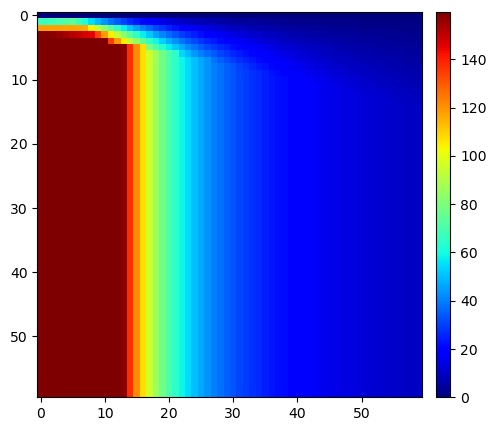

In [ ]:
def calc_P(diameter_km, r_km, z_km):
    
    ## unit conversions
    diameter_m = diameter_km * 1000
    r_m = r_km * 1000 # horizontal distance from impact site
    z_m = z_km * 1000 # depth from floor of crater (?)
    
    
    ## start complicated math shit -- NOTE THAT EVERYTHING IS IN SI, I.E. METERS NOT KILOMETERS!!!
    
    diam_obs = diameter_m # observed crater diameter
    diam_star = 7 * 1000 # transition diameter from simple to complex crater, assumed 7km for mars
    diam_trans = 0.7576 * (diam_obs ** 0.921) * (diam_star ** 0.079)
    # print(diam_trans / 1000)
    
    v_proj = 10 * 1000 # impact velocity, varies from 8-12 km/s, assumed 10 km/s
    g = 3.721 # surface gravity
    E = ((diam_trans * v_proj**0.09 * g**0.22)/(0.2212)) ** (1/0.26) # energy of impactor
    
    rho = 2900 # density of impactor, assumed 2900 kg/m^3 for basaltic
    r_proj = ((3 * E)/(2 * math.pi * rho * v_proj**2))**(1/3) # radius of impactor, assumed to be spherical basaltic projectile
    
    R_0 = 0.75 * r_proj # radius of isobaric core, ~70% of projectile radius
    
    C_basalt = 3.5 * 1000 # bulk speed of sound in material, assumed 3.5 km/s for kinosaki basalt
    S_basalt = 1.5 # shock parameter of material, assumed 1.5 for kinosaki basalt
    
    P_0 = 0.25 * rho * v_proj * (2*C_basalt + S_basalt*v_proj) # isobaric pressure (within isobaric core)
    
    R_direct = math.sqrt( (z_m - R_0)**2 + r_m**2 ) # distance travelled by direct pressure waves
    R_reflect = math.sqrt( (z_m + R_0)**2 + r_m**2 ) # distance travelled by reflected pressure waves
    
    tau = (R_reflect - R_direct) / C_basalt # time delay between arrival of initial and reflected pressure waves
    tau_rise = r_proj / v_proj # time rise (?)
    
    def naive_P(this_r):
        # if (this_r == 0):
        #     return 0
        if (this_r <= R_0):
            P = P_0
        else:        
            n = 1.87 # exponential decay constant, assumed invariant with distance from impact
            P = P_0 * ((this_r / R_0) ** -n)
        return P
    
    if (tau > tau_rise):
        P = naive_P(r_m)
    else: # reduced peak pressure due to interference of waves
        P = naive_P(R_direct) - naive_P(R_reflect) * (1 - (tau / tau_rise)) 
        
    P = P * 1e-9 # adjust to units of gigapascals

    return P



###################################
# calc_P(henry["diameter_km"], 10, 10)

pressures = []
for depth in range(60):
    newline = []
    for distance in range(60):
        newline.append(calc_P(henry["diameter_km"], distance, depth))
    pressures.append(newline)

fig = plt.figure(figsize=(7,5))
ax = plt.axes()
im = ax.imshow(pressures, cmap="jet")

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)



# print(calc_P(henry["diameter_km"], 30, 30))